# Работа будет состоять из следующих шагов:
[Шаг 1. Загрузим данные и подготовим их к анализу.](#cell1)

Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный. 

[Шаг 2. Построим отчёты и посчитаем метрики](#cell2)

[Продукт](#cell3)
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

[Продажи](#cell4)
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

[Маркетинг](#cell5)
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

[Шаг 3. Напишем вывод: порекомендем маркетологам, куда и сколько им стоит вкладывать денег?](#cell6)

Какие источники/платформы мы бы порекомендовали? Объясним свой выбор: на какие метрики мы ориентируемся? Почему? Какие выводы мы сделали, узнав значение метрик?

<a id='cell1'></a>
# Шаг 1. Загрузим данные и подготовим их к анализу.

Для начала импортируем все библиотеки, которые пригодятся нам в проекте:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import plotly.express as px

Сохраним все файлы в датафреймы:

In [2]:
visits = pd.read_csv('visits_log.csv')

In [3]:
orders = pd.read_csv('orders_log.csv')

In [4]:
costs = pd.read_csv('costs.csv')

Теперь выведем первые 5 строк датафрейма `visits` и информацию о нем:

In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Видим, что пропусков нет (ура!), но видим, что нужно переименовать столбцы для более удобного использования датафрейма и поменять тип данных у столбцов `End Ts` и `Start Ts` на datetime.

Для начала переименуем столбцы:

In [7]:
visits.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'uid']

Теперь поменяем тип данных:

In [8]:
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'], format = '%Y-%m-%d %H:%M:%S')

Проверим, что все столбцы названы нормально и тип данных теперь верный:

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
session_end_ts      359400 non-null datetime64[ns]
source_id           359400 non-null int64
session_start_ts    359400 non-null datetime64[ns]
uid                 359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Все ок! Можем приступать к следующему датафрейму.

Теперь выведем первые 5 строк датафрейма `orders` и информацию о нем:

In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Видим, что пропусков нет (ура!), но видим, что нужно переименовать столбцы для более удобного использования датафрейма и поменять тип данных у столбца `Buy Ts` на datetime.

Для начала переименуем столбцы:

In [12]:
orders.columns = ['buy_date', 'revenue', 'uid']

Теперь поменяем тип данных:

In [13]:
orders['buy_date'] = pd.to_datetime(orders['buy_date'], format = '%Y-%m-%d %H:%M:%S')

Проверим, что все столбцы названы нормально и тип данных теперь верный:

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_date    50415 non-null datetime64[ns]
revenue     50415 non-null float64
uid         50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Все ок! Можем приступать к следующему датафрейму.

Теперь выведем первые 5 строк датафрейма `costs` и информацию о нем:

In [15]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Видим, что пропусков нет (ура!), но видим, что нужно переименовать столбцы для более удобного использования датафрейма и поменять тип данных у столбцов `dt` на datetime.

Для начала переименуем столбцы:

In [17]:
costs.columns = ['source_id', 'date', 'costs']

Теперь поменяем тип данных:

In [18]:
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d')

Проверим, что все столбцы названы нормально и тип данных теперь верный:

In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Все ок!

## Вывод
Мы выгрузили из файлов данные в датафреймы, оказалось, что пропусков в данных не было, так что мы переименовали столбцы для дальнейшего удобства и изменили тип данных в столбцах содержащих даты на datetime. Теперь с данными будет удобно работать.

<a id='cell2'></a>
# Шаг 2. Построим отчёты и посчитаем метрики.

<a id='cell3'></a>
## Продукт

### Сколько людей пользуются в день, неделю, месяц?
Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

Для ответа на этот вопрос, выделим день, неделю, месяц и год из поля `session_start_ts`:

In [20]:
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_month'] = visits['session_start_ts'].dt.month
visits['session_week']  = visits['session_start_ts'].dt.week
visits['session_date'] = visits['session_start_ts'].dt.date

Посчитаем средние DAU, WAU, MAU за весь период:

In [21]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'}).mean()
print('MAU: {}'.format(int(mau_total)))

MAU: 23228


In [22]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid' : 'nunique'}).mean()
print('WAU: {}'.format(int(wau_total)))

WAU: 5716


In [23]:
dau_total = visits.groupby(['session_date']).agg({'uid' : 'nunique'}).mean()
print('DAU: {}'.format(int(dau_total)))

DAU: 907


Найдем средние DAU/WAU, DAU/MAU:

In [24]:
sticky_wau = dau_total / wau_total * 100
print('sticky WAU: {}'.format(int(sticky_wau)))

sticky WAU: 15


In [25]:
sticky_mau = dau_total / mau_total * 100
print('sticky MAU: {}'.format(int(sticky_mau)))

sticky MAU: 3


Теперь посмотрим, как зависят DAU, WAU, MAU, sticky_wau, sticky_mau от девайса:

Для этого напишем функцию, которая будет считать все метрики роста в зависимости от нужного параметра (чтобы потом это можно было переиспользовать для другого параметра)

In [26]:
def groth_metrics(data, parameter):
    growth_metrics_by_parameter = pd.DataFrame(columns = [parameter, 'DAU', 'WAU', 'MAU', 'sticky_wau', 'sticky_mau'])
    counter = 0
    for uniq_parameter in data[parameter].unique():
        growth_metrics_by_parameter.loc[counter, parameter] = uniq_parameter
        growth_metrics_by_parameter.loc[counter, 'DAU'] = int(data[data[parameter] == uniq_parameter]
                                                 .groupby(['session_date'])
                                                 .agg({'uid' : 'nunique'})
                                                 .mean())
        growth_metrics_by_parameter.loc[counter, 'WAU'] = int(data[data[parameter] == uniq_parameter]
                                                 .groupby(['session_year', 'session_week'])
                                                 .agg({'uid' : 'nunique'})
                                                 .mean())
        growth_metrics_by_parameter.loc[counter, 'MAU'] = int(data[data[parameter] == uniq_parameter]
                                                 .groupby(['session_year', 'session_month'])
                                                 .agg({'uid' : 'nunique'})
                                                 .mean())
        growth_metrics_by_parameter.loc[counter, 'sticky_wau'] = (growth_metrics_by_parameter.loc[counter, 'DAU'] 
                                                                / growth_metrics_by_parameter.loc[counter, 'WAU'] 
                                                                * 100)
        growth_metrics_by_parameter.loc[counter, 'sticky_mau'] = (growth_metrics_by_parameter.loc[counter, 'DAU'] 
                                                                / growth_metrics_by_parameter.loc[counter, 'MAU'] 
                                                                * 100)
        counter += 1
    return growth_metrics_by_parameter

In [27]:
growth_metrics_by_device = groth_metrics(visits, 'device')

In [28]:
growth_metrics_by_device

,device,DAU,WAU,MAU,sticky_wau,sticky_mau
0,touch,252,1634,6825,15.4223,3.69231
1,desktop,659,4129,16724,15.9603,3.94044


Для наглядности изобразим это на диаграмах. 
Для этого напишем функцию, которая будет строить диаграмы по получившемуся датафрейму с метриками:

In [29]:
def groth_graphs(data, parameter):
    for metric in ['DAU', 'WAU', 'MAU', 'sticky_wau', 'sticky_mau']:
        data.plot(x=parameter, y=metric, kind='bar');
        plt.xlabel(parameter);
        plt.ylabel(metric);
        plt.title('{} в зависимости от {}'.format(metric, parameter));

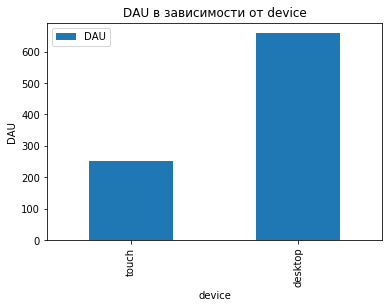

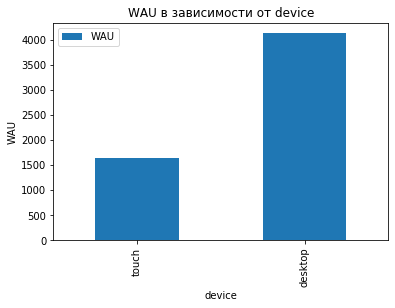

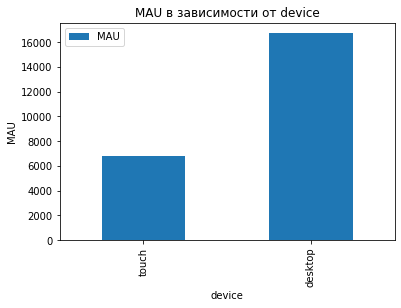

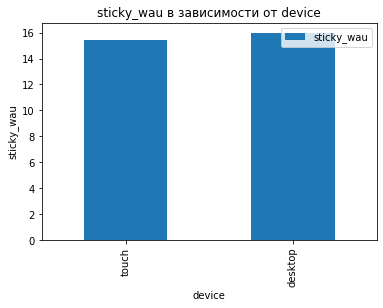

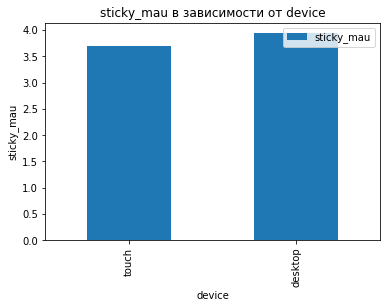

In [30]:
groth_graphs(growth_metrics_by_device, 'device')

Теперь посмотрим, как зависят DAU, WAU, MAU, sticky_wau, sticky_mau от рекламного источника:
(переиспользуем функцию)

In [31]:
growth_metrics_by_source = groth_metrics(visits, 'source_id')

In [32]:
growth_metrics_by_source

,source_id,DAU,WAU,MAU,sticky_wau,sticky_mau
0,4,275,1829,7765,15.0355,3.54153
1,2,120,715,2752,16.7832,4.36047
2,5,175,1167,5017,14.9957,3.48814
3,9,36,238,987,15.1261,3.64742
4,3,232,1565,6758,14.8243,3.43297
5,1,80,463,1818,17.2786,4.40044
6,10,26,166,707,15.6627,3.67751
7,7,1,1,2,100,50
8,6,1,1,1,100,100


Для наглядности изобразим это на диаграмах. 
(переиспользуем функцию)

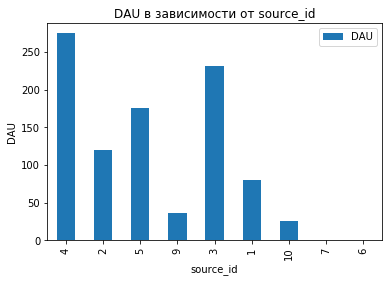

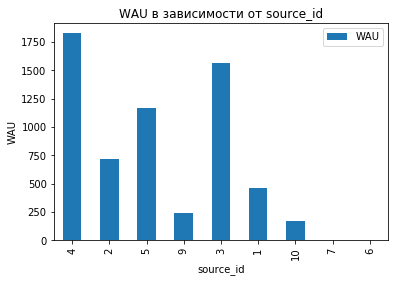

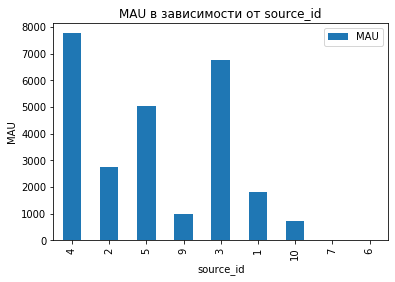

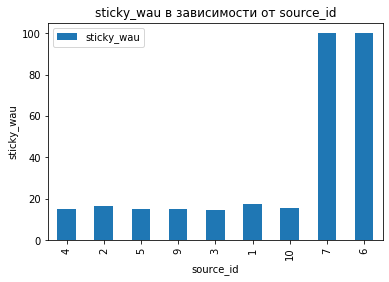

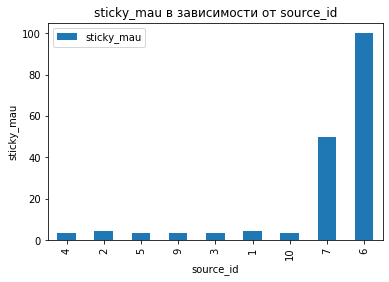

In [33]:
groth_graphs(growth_metrics_by_source, 'source_id')

Теперь посмотрим, как менялись метрики во времени:

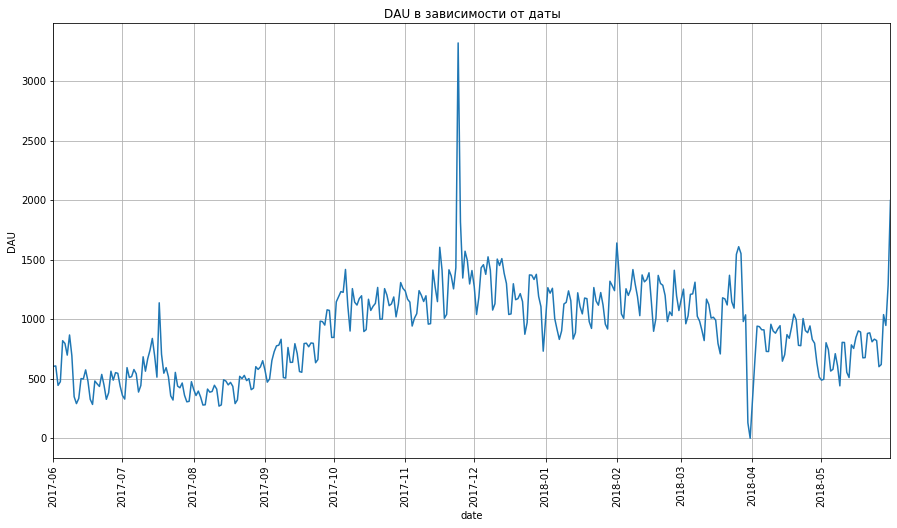

In [34]:
(visits
 .groupby(['session_date'])
 .agg({'uid' : 'nunique'})
 .plot(y='uid', figsize=(15, 8), legend=None, grid=True));
plt.xticks(rotation=90)
plt.xlabel('date');
plt.ylabel('DAU');
plt.title('DAU в зависимости от даты');

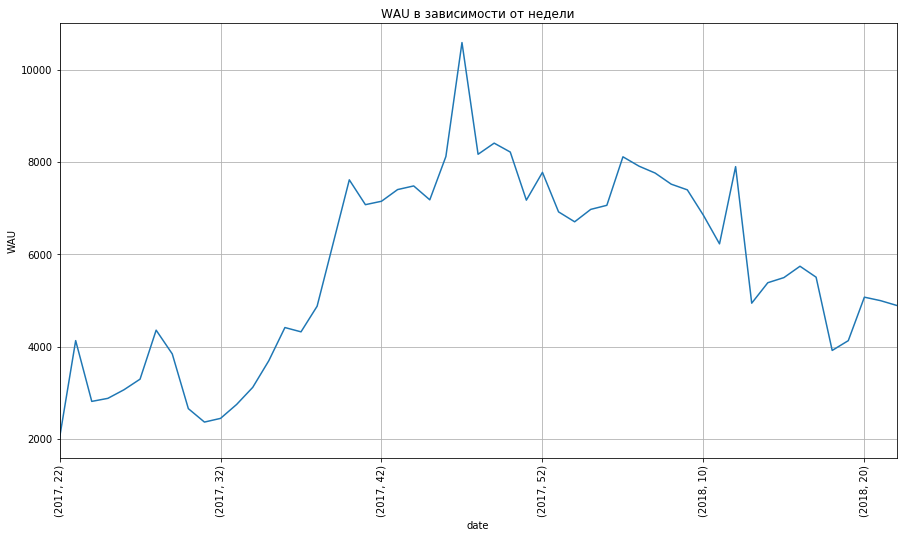

In [35]:
(visits
 .groupby(['session_year', 'session_week'])
 .agg({'uid' : 'nunique'})
 .plot(y='uid', figsize=(15, 8), legend=None, grid=True));
plt.xticks(rotation=90)
plt.xlabel('date');
plt.ylabel('WAU');
plt.title('WAU в зависимости от недели');

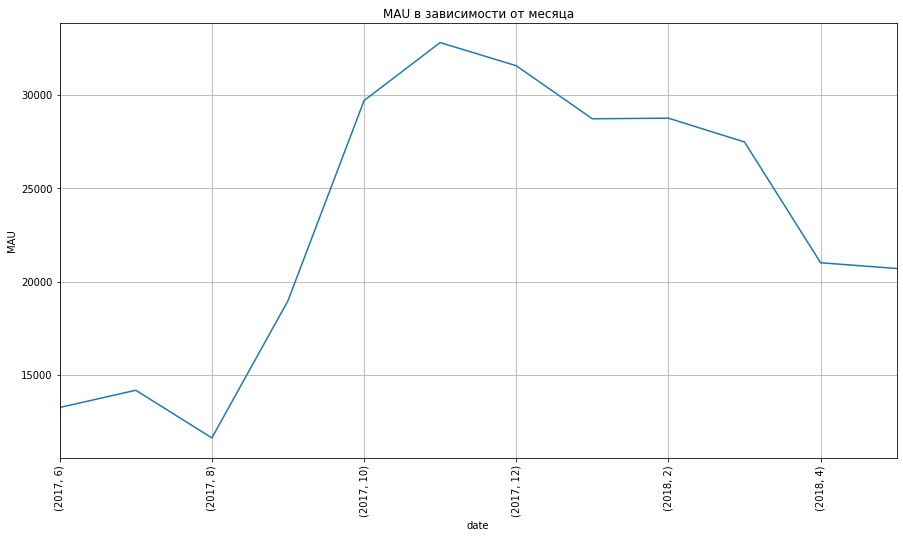

In [36]:
(visits
 .groupby(['session_year', 'session_month'])
 .agg({'uid' : 'nunique'})
 .plot(y='uid', figsize=(15, 8), legend=None, grid=True));
plt.xticks(rotation=90)
plt.xlabel('date');
plt.ylabel('MAU');
plt.title('MAU в зависимости от месяца');

### Вывод:
В среднем в Яндекс.Афиша с июня 2017 года по май 2018 было:
- 907 уникальных пользователей в день
- 5716 уникальных пользователей в неделю
- 23228 уникальных пользователей в месяц
При этом средний DAU/WAU в этом периоде составил 15% и DAU/MAU 3%. Можем сделать предварительный вывод, что Яндекс.Афишей пользуются не постоянно (не кажды день), редко, иначе бы DAU/WAU и DAU/MAU стремились бы к 100%.

Также мы посмотрели, как все эти параметры зависят от устройства, и оказалось, что с десктопа заходят чаще, чем с тачскринов примерно в 2.5 раза (об этом говорят DAU, MAU, WAU), но при этом DAU/WAU и DAU/MAU примерно одинаковые для разных платформ, поэтому можем сделать вывод, что частота дальнейшего использования от девайса не зависит.

Также мы посмотрели, как все эти параметры зависят от источника трафика, и оказалось, что чаще всего заходят из источников 4, 3 и 5 (об этом говорят DAU, MAU, WAU), тогда как источники 7 и 6 привлекают меньше всего трафика (а источник 8 вообще не встретился в датасете). При этом DAU/WAU и DAU/MAU примерно одинаковые для всех источников (от, кроме 6 и 7 (но там слишком мало данных, чтобы нормально об этом судить): 15-17 в случае DAU/WAU и 3.5-4.5 в случае DAU/MAU, поэтому можем сделать вывод, что частота дальнейшего использования от источника также не зависит.

Также мы посмотрели, как DAU, MAU, WAU меняются во времени: 
По DAU можно заметить большой пик (около 3300) в конце ноября, который повлиял также на MAU и WAU. Возможно, в этот день выложили какой-то анонс или билеты на какой-то крутой концерт? или на новогодние ёлки для детей? В остальные дни с июня по октябрь 2017 в среднем было около 500 уникальных пользователей в день, а с октября 2017 по апрель 2018 в среднем около 1200, а после этого пошло на спад и в среднем было около 750. 

И по WAU и MAU мы видим рост уникальных пользователей за период с августа по ноябрь 2017, а после ноября плавный спад.

### Сколько сессий в день?
Отобразим на графике, как эта метрика меняется со временем с разбивкой по месяцам

Для начала посчитаем среднее количество сессий в день за период

In [37]:
sessions_per_day_total = visits.groupby(['session_date']).agg({'uid' : 'count'}).mean()
print('среднее количество сессий в день за период: {}'.format(int(sessions_per_day_total)))


среднее количество сессий в день за период: 987


Теперь построим график как меняется среднее количество сессий в день с разбивкой по месяцам:

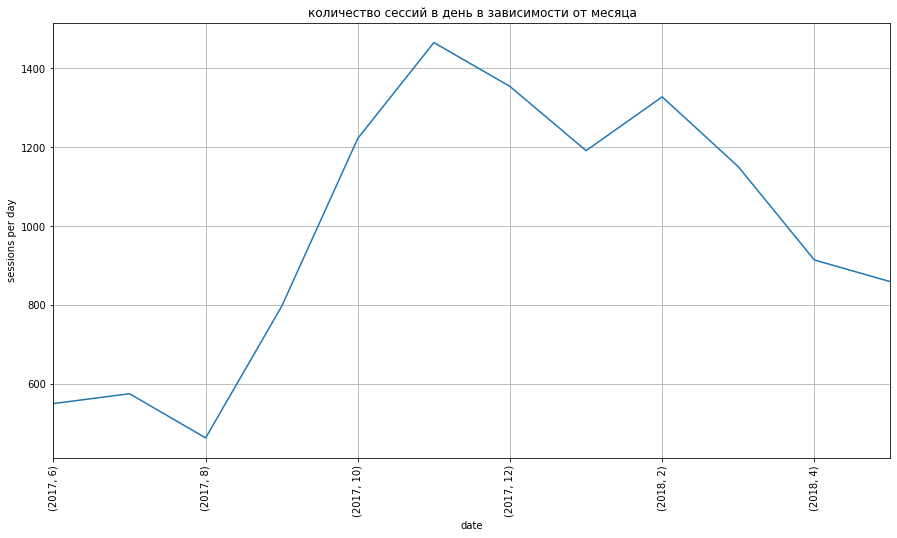

In [38]:
(visits
 .groupby(['session_year','session_month', 'session_date'])
 .agg({'uid' : 'count'})
 .groupby(['session_year','session_month'])
 .agg({'uid' : 'mean'})
 .plot(y='uid', figsize=(15, 8), legend=None, grid=True));
plt.xticks(rotation=90)
plt.xlabel('date');
plt.ylabel('sessions per day');
plt.title('количество сессий в день в зависимости от месяца');

### Вывод:
В среднем в Яндекс.Афиша с июня 2017 года по май 2018 было 987 сессий в день.
И по графику (среднее количество сессий в день с разбивкой по месяцам) мы видим рост среднего количества сессий в день за период с августа по ноябрь 2017, а после ноября плавный спад. Как и у MAU.

### Сколько длится одна сессия?
Исследуем распределение длительности сессий. Построим гистограмму, боксплот, найдем среднюю и медианную длительность сессии.

Для этого нам нужно вычислить длительность каждой сессии в секундах:

In [39]:
visits['session_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds

Теперь построим гистрограмму, ящик с усами и выведем характерные значения:

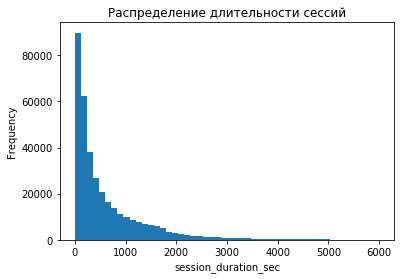

In [40]:
visits['session_duration_sec'].plot(kind='hist', bins=50, range=(0, 6000))
plt.xlabel('session_duration_sec');
plt.title('Распределение длительности сессий');

In [41]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [42]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

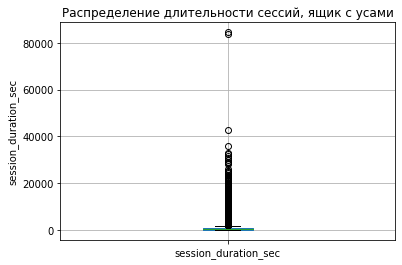

In [43]:
visits.boxplot('session_duration_sec')
plt.ylabel('session_duration_sec');
plt.title('Распределение длительности сессий, ящик с усами');

Посмотрим на график поближе, без выбросов. 
Для этого найдем верхнюю и нижнюю границу ящика, чтобы потом ограничить график ими.

In [44]:
IQR = 840 + 120
upper_border = 840 + 1.5 * IQR
bottom_border = 120 - 1.5 * IQR
if bottom_border < 0:
    bottom_border = 0

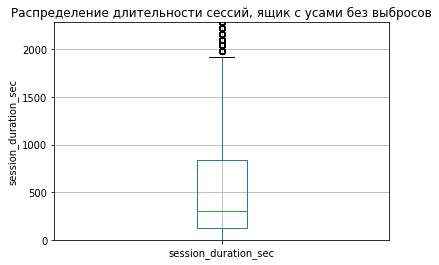

In [45]:
visits.boxplot('session_duration_sec')
plt.ylabel('session_duration_sec');
plt.ylim(bottom_border, upper_border) 
plt.title('Распределение длительности сессий, ящик с усами без выбросов');

### Вывод
Длительность сессий распределена по Пуассону, средняя длинна сессии составляет 643 секунды (10.5 минут), медианная 300 секунд (5 минут), а мода 60 секунд. Также мы видим большое количество выбросов на ящике с усами. удалять мы их не будем, так как не будем проводить статтесты. 

### Как часто люди возвращаются?
Построим таблицу с Retention с месячными когортами. 

Сначала найдем и добавим в таблицу первый день сессии для каждого юзера

In [46]:
first_activity_date = visits.groupby(['uid'])['session_start_ts'].min()
first_activity_date.name = 'first_session_date'
visits = visits.join(first_activity_date,on='uid')

Для дальнейшего удобства переведем обе даты в месяц:

In [47]:
visits['session_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

теперь для каждой сессии посчитаем `cohort_lifetime`:

In [48]:
visits['cohort_lifetime'] = (round(
    (visits['session_month'] - visits['first_session_month']) 
    / np.timedelta64(1,'M'))).astype('int')


Теперь сгруппируем данные:

In [49]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

Найдём исходное количество пользователей в когорте

In [50]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [51]:
cohorts = cohorts.merge(initial_users_count,on='first_session_month')

Расчитаем ретеншен

In [52]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

In [53]:
retention_pivot = (cohorts
                   .pivot_table(index='first_session_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
                   .drop(columns = [0]))

In [54]:
retention_pivot

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


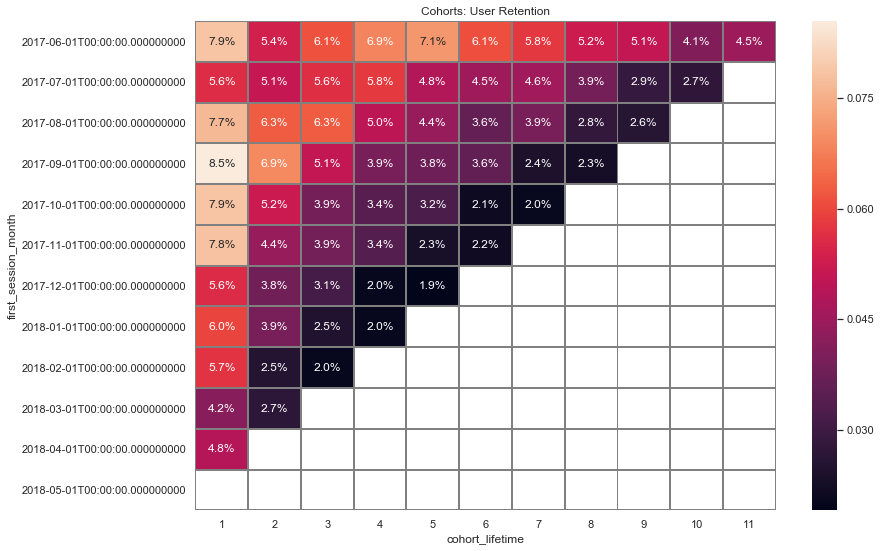

In [55]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Посчитаем средний ретеншен по всем когортам:

In [56]:
retention_pivot.mean(axis=0)

cohort_lifetime
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
11    0.044951
dtype: float64

### Вывод
Мы рассчитали ретеншен для месячных когорт. В среднем во второй месяц использования возвращается только 6.5% всех пользователей, и от месяца к месяцу в среднем это значение падает, и к десятому месяцу остается только 3.5% от всех пользователей.
Также можно заметить, что чем старше когорта, тем хуже она возвращается. Например если сравнить когорты июня и декабря 2017 года, можно увидеть, что процент вернувшихся людей на 5 месяц в 3 раза больше у более ранней когорты. 
Возможно это сезонность, а возможно и ухудшающие изменения в продукте. Нужно посмотреть на это повнимательнее.

<a id='cell4'></a>
## Продажи

### Когда люди начинают покупать?
Посчитаем количество секунд от начала первой сессии до первой покупки.
Построим гистограмму, боксплот, найдем среднее и медианное время до первой покупки.

Сначала найдем и добавим в таблицу `visits` первый день покупки для каждого юзера

In [57]:
first_buy_date = orders.groupby('uid')['buy_date'].min()
first_buy_date.name = 'first_buy_date'
visits = visits.join(first_buy_date,on='uid')

Теперь найдем время от первой сессии до первой покупки в секундах

In [58]:
visits['duration_till_first_buy_sec'] = (visits['first_buy_date'] - visits['first_session_date']).dt.seconds

сгруппируем таблицу так, чтобы для каждого юзера найти время от первой сессии до первой покупки в секундах

In [59]:
time_to_buy = visits.groupby('uid')['duration_till_first_buy_sec'].mean().reset_index()

Во первых посмотрим, какая часть пользователей вообще что-то купили:

In [60]:
len(time_to_buy[~time_to_buy['duration_till_first_buy_sec'].isnull()])/len(time_to_buy)*100

16.006994815246596

Теперь для купивших построим гистрограмму, ящик с усами и выведем характерные значения:

In [61]:
time_to_buy[~time_to_buy['duration_till_first_buy_sec'].isnull()]['duration_till_first_buy_sec'].describe()

count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: duration_till_first_buy_sec, dtype: float64

In [62]:
time_to_buy[~time_to_buy['duration_till_first_buy_sec'].isnull()]['duration_till_first_buy_sec'].mode()

0    60.0
dtype: float64

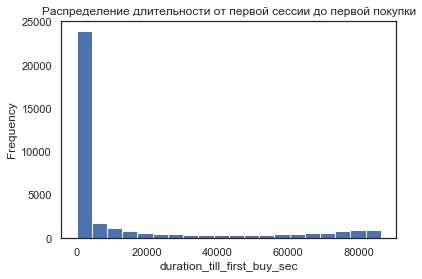

In [63]:
time_to_buy[~time_to_buy['duration_till_first_buy_sec'].isnull()]['duration_till_first_buy_sec'].plot(kind='hist', bins=20)
plt.xlabel('duration_till_first_buy_sec');
plt.title('Распределение длительности от первой сессии до первой покупки');

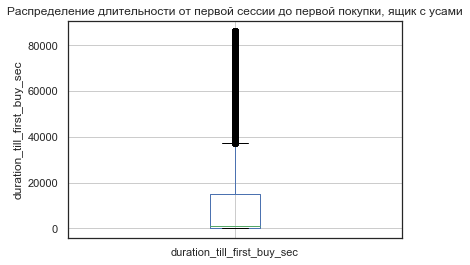

In [64]:
time_to_buy[~time_to_buy['duration_till_first_buy_sec'].isnull()].boxplot('duration_till_first_buy_sec')
plt.ylabel('duration_till_first_buy_sec');
plt.title('Распределение длительности от первой сессии до первой покупки, ящик с усами');

### Вывод
Длительность от первой сессии до покупки распределена не по Пуассону (так как есть небольшой второй горб), средняя длительность составляет 14950 секунд (примерно 4 часа), медианная 960 секунд (16 минут), а мода 60 секунд. Также мы видим большое количество выбросов на ящике с усами, на них же приходится второй небольшой горб. удалять мы их не будем, так как не будем проводить статтесты.
Также мы узнали, что только 16% пользователей вообще совершили покупку.

### Сколько раз покупают за период?
Посчитаем количество покупок в месяц с разбивкой по устройствам и источникам.

Для начала определим источник и девайс для каждого пользователя:

In [65]:
sources = visits.sort_values(by = ['uid', 'session_start_ts']).groupby('uid').agg({'source_id': 'first'})
devices = visits.sort_values(by = ['uid', 'session_start_ts']).groupby('uid').agg({'device': 'first'})

теперь добавим источник и девайс в таблицу с покупками:

In [66]:
orders = orders.join(sources,on='uid')
orders = orders.join(devices,on='uid')

In [67]:
orders['buy_year']  = orders['buy_date'].dt.year
orders['buy_month'] = orders['buy_date'].dt.month

In [68]:
groupped_buy = orders.groupby(['buy_year', 'buy_month'])['uid'].count()

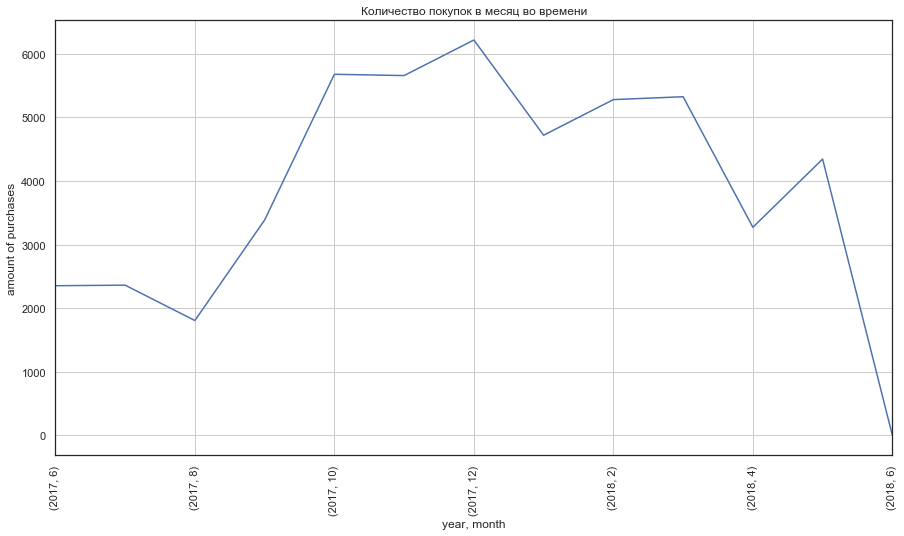

In [69]:
groupped_buy.plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('amount of purchases');
plt.title('Количество покупок в месяц во времени');

Посчитаем средее количество покупок в месяц за весь период:

In [70]:
print('средее количество покупок в месяц за весь период: {}'.format(groupped_buy.mean()))


средее количество покупок в месяц за весь период: 3878.076923076923


Теперь посмотрим, как зависит количество покупок в месяц от устройства и источника трафика.

In [71]:
pivot_buy_devices = orders.pivot_table(index=['buy_year', 'buy_month'], columns='device', values='uid', aggfunc='count')

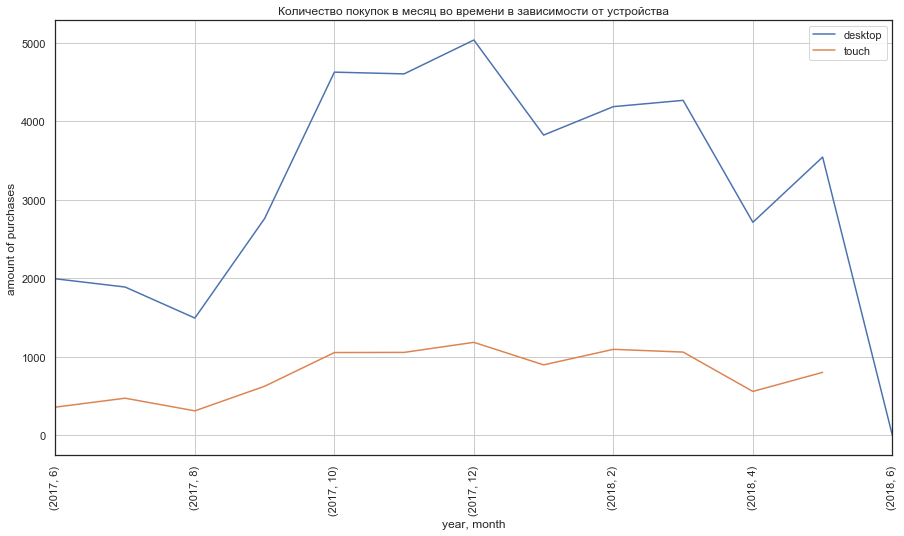

In [72]:
pivot_buy_devices.plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('amount of purchases');
plt.legend()
plt.title('Количество покупок в месяц во времени в зависимости от устройства');

In [73]:
pivot_buy_source = orders.pivot_table(index=['buy_year', 'buy_month'], columns='source_id', values='uid', aggfunc='count')

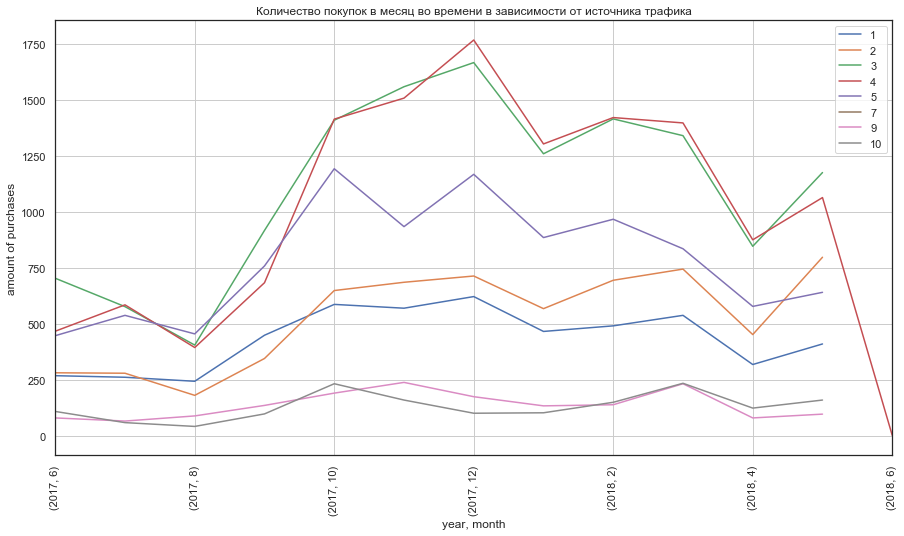

In [74]:
pivot_buy_source.plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('amount of purchases');
plt.legend()
plt.title('Количество покупок в месяц во времени в зависимости от источника трафика');

Теперь посмотрим те же показатели, только из расчета на 1 пользователя:

In [75]:
groupped_by_buyer = orders.groupby(['buy_year', 'buy_month']).agg({'uid': ['nunique', 'count']})
groupped_by_buyer.columns = ['unique_users', 'buy_amount']
groupped_by_buyer['buys_per_user'] = groupped_by_buyer['buy_amount'] / groupped_by_buyer['unique_users']

В среднем покупатель делает столько покупок:

In [76]:
print('В среднем покупатель делает столько покупок: {}'.format(groupped_by_buyer['buys_per_user'].mean()))

В среднем покупатель делает столько покупок: 1.2058233446244648


Построим график, как меняется среднее количество покупок на 1 платящего пользователя в месяц:

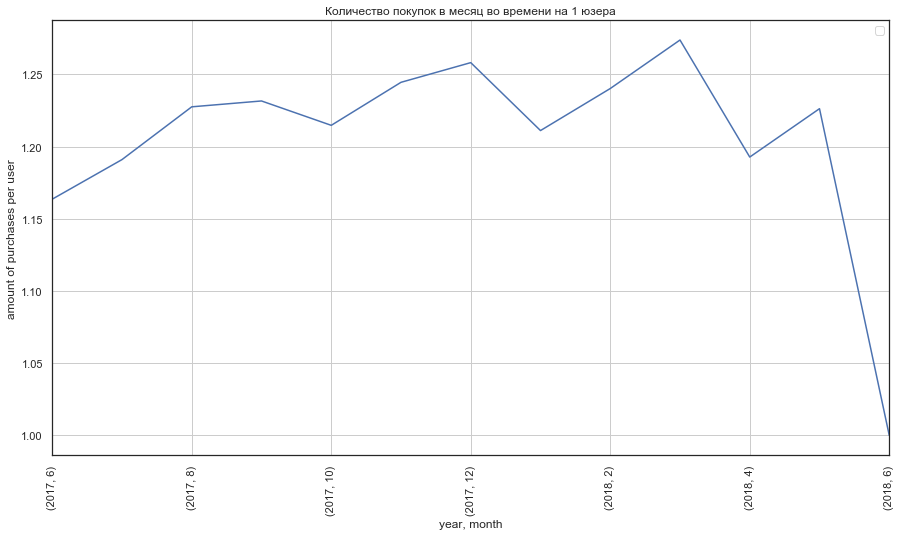

In [77]:
groupped_by_buyer['buys_per_user'].plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('amount of purchases per user');
plt.legend('')
plt.title('Количество покупок в месяц во времени на 1 юзера');

Теперь построим такой же график, только для разных источников:

In [78]:
groupped_by_buyer_and_source = orders.groupby(['buy_year', 'buy_month', 'source_id']).agg({'uid': ['nunique', 'count']})
groupped_by_buyer_and_source.columns = ['unique_users', 'buy_amount']
groupped_by_buyer_and_source['buys_per_user'] = (groupped_by_buyer_and_source['buy_amount'] 
                                                 / groupped_by_buyer_and_source['unique_users'])

In [79]:
pivot_by_buyer_and_source = groupped_by_buyer_and_source.pivot_table(index=['buy_year', 'buy_month'], 
                                                                     columns='source_id', 
                                                                     values='buys_per_user', 
                                                                     aggfunc='mean')

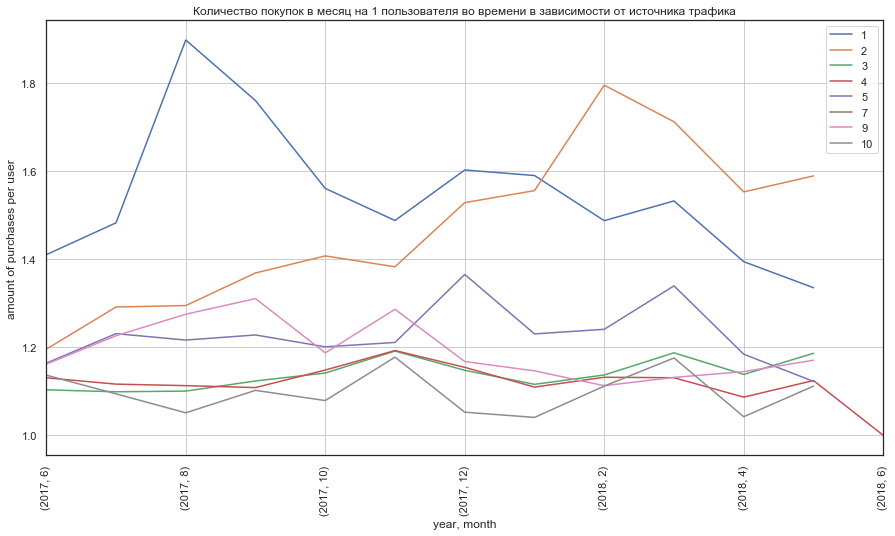

In [80]:
pivot_by_buyer_and_source.plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('amount of purchases per user');
plt.legend()
plt.title('Количество покупок в месяц на 1 пользователя во времени в зависимости от источника трафика');

### Вывод
Количество покупок в месяц схоже по поведению с MAU, которое мы визуализировали ранее. Также наблюдается рост с августа по декабрь 2017, а дальше спад до конца периода. 
Среднее количество покупок в месяц за весь период - 3878.
Также, как и в MAU видим, что по покупкам лидирует десктоп перед тачскрином, и источники 3, 4, 5 перед всеми остальными.

Среднее количество покупок на 1 платящего юзера - 1.2
1 и 2 источники приносят наибольшее среди остальных источников среднее количество покупок на 1 пользователя. Что улучшит в будушем LTV у этих источников.

### Какой средний чек?
Посчитаем средний чек за месяц в зависимости от месяца

In [81]:
ARPU_per_month = (orders
                  .groupby(['buy_year', 'buy_month'])['revenue'].mean())

посмотрим средний чек за месяц за весь период

In [82]:
print('средний чек за месяц за весь период: {}'.format(ARPU_per_month.mean()))

средний чек за месяц за весь период: 4.838699619166338


Построим график как меняется средний чек за месяц с течением времени

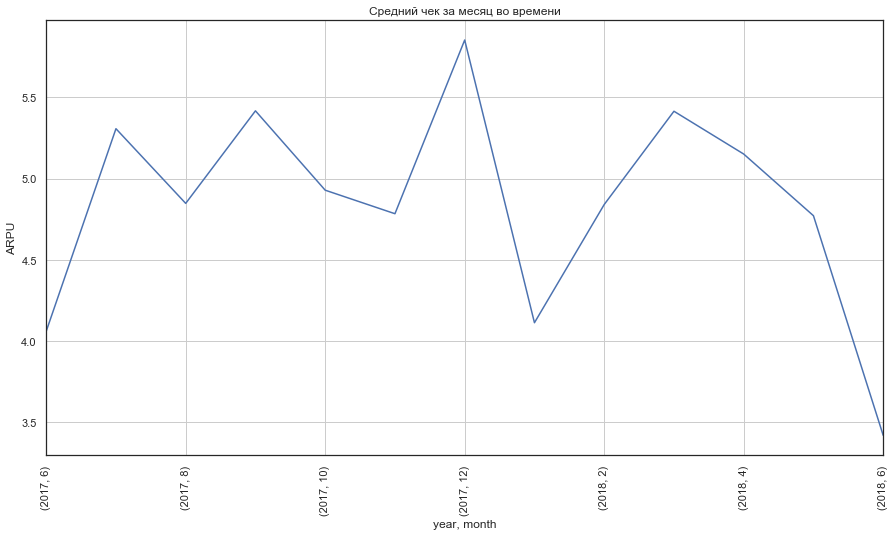

In [83]:
ARPU_per_month.plot(figsize=(15, 8), legend=None, grid=True);
plt.xticks(rotation=90)
plt.xlabel('year, month');
plt.ylabel('ARPU');
plt.title('Средний чек за месяц во времени');

### Вывод
Средний чек за месяц за весь период - 5.86.
Также видим пик в декабре (видимо, покупали билеты на какие-то новогодние мероприятия), а также резкий спад в январе - не удивительно, в январе всегда снижается покупательная способность Россиян из-за больших трат перед новым годом.

### Сколько денег приносят? (LTV) с разбивкой по источникам

соединяем первые покупки и источники 

In [84]:
payers = orders.groupby('uid').agg({'buy_date': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_date': 'first_buy'})
payers

,uid,first_buy,source_id
0,313578113262317,2018-01-03 21:51:00,2
1,1575281904278712,2017-06-03 10:13:00,10
2,2429014661409475,2017-10-11 18:33:00,3
3,2464366381792757,2018-01-28 15:54:00,5
4,2551852515556206,2017-11-24 10:14:00,5
...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,5
36519,18445407535914413204,2017-09-22 23:55:00,3
36520,18445601152732270159,2018-03-26 22:54:00,2
36521,18446156210226471712,2018-02-18 19:34:00,3


Посчитаем ltv:

In [85]:
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_date'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv.drop(['source_id_y'], axis='columns', inplace=True)
ltv = ltv.rename(columns = {'source_id_x': 'source_id'})
ltv

,uid,first_buy,source_id,buy_date,revenue,device,buy_year,buy_month,lifetime
0,313578113262317,2018-01-03 21:51:00,2,2018-01-03 21:51:00,0.55,desktop,2018,1,0
1,1575281904278712,2017-06-03 10:13:00,10,2017-06-03 10:13:00,1.22,touch,2017,6,0
2,1575281904278712,2017-06-03 10:13:00,10,2017-06-03 17:39:00,1.83,touch,2017,6,0
3,2429014661409475,2017-10-11 18:33:00,3,2017-10-11 18:33:00,73.33,desktop,2017,10,0
4,2464366381792757,2018-01-28 15:54:00,5,2018-01-28 15:54:00,2.44,desktop,2018,1,0
...,...,...,...,...,...,...,...,...,...
50410,18445407535914413204,2017-09-22 23:55:00,3,2017-09-24 23:48:00,0.24,desktop,2017,9,0
50411,18445407535914413204,2017-09-22 23:55:00,3,2017-09-25 15:56:00,0.12,desktop,2017,9,0
50412,18445601152732270159,2018-03-26 22:54:00,2,2018-03-26 22:54:00,4.22,desktop,2018,3,0
50413,18446156210226471712,2018-02-18 19:34:00,3,2018-02-18 19:34:00,9.78,desktop,2018,2,0


In [86]:
orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)
ltv

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,17846.78,20730.27,22876.46,24750.95,26175.95,26818.89,27615.37,28604.02,29544.45,30297.05,30606.37,30942.50,31090.55
2,23737.70,28239.92,34071.03,39455.25,41721.84,43770.27,44601.29,45397.02,46178.78,46396.86,46794.56,46911.76,46923.61
3,46894.89,49529.78,50958.98,52450.34,53235.23,53648.88,53904.56,54183.84,54379.52,54433.18,54487.87,54499.75,54511.24
4,47204.71,48783.77,49959.05,50950.96,52183.86,53812.69,55004.97,55505.99,55704.86,56095.12,56655.05,56683.39,56696.83
5,34030.40,35446.46,37912.39,47385.50,49021.21,50224.35,51048.22,51670.59,52087.36,52511.13,52556.01,52622.25,52624.02
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22
9,4222.42,4534.12,4795.93,5090.63,5209.55,5369.92,5504.33,5577.75,5705.94,5750.05,5759.40,5759.40,5759.40
10,4205.13,4289.26,4325.49,4389.10,4407.73,4411.24,4429.19,4443.31,4446.97,4450.33,4450.33,4450.33,4450.33


In [87]:
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12,cohort_size
source_id,,,,,,,,,,,,,,
1,17846.78,20730.27,22876.46,24750.95,26175.95,26818.89,27615.37,28604.02,29544.45,30297.05,30606.37,30942.50,31090.55,2899
2,23737.70,28239.92,34071.03,39455.25,41721.84,43770.27,44601.29,45397.02,46178.78,46396.86,46794.56,46911.76,46923.61,3506
3,46894.89,49529.78,50958.98,52450.34,53235.23,53648.88,53904.56,54183.84,54379.52,54433.18,54487.87,54499.75,54511.24,10473
4,47204.71,48783.77,49959.05,50950.96,52183.86,53812.69,55004.97,55505.99,55704.86,56095.12,56655.05,56683.39,56696.83,10296
5,34030.40,35446.46,37912.39,47385.50,49021.21,50224.35,51048.22,51670.59,52087.36,52511.13,52556.01,52622.25,52624.02,6931
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1
9,4222.42,4534.12,4795.93,5090.63,5209.55,5369.92,5504.33,5577.75,5705.94,5750.05,5759.40,5759.40,5759.40,1088
10,4205.13,4289.26,4325.49,4389.10,4407.73,4411.24,4429.19,4443.31,4446.97,4450.33,4450.33,4450.33,4450.33,1329


In [88]:
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


### Вывод
Мы посчитали LTV для каждого источника, получилось, что на 12ый месяц самый большой LTV у источников 1 (13.4) и 2 (10.7), а самый маленький у 10 (3.3) (7ой не берем в счет, так там только 1 пользователь).

<a id='cell5'></a>
## Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени
Для этого проанализируем таблицу `costs`

Всего на маркетинг за все время потратили:

In [89]:
costs['costs'].sum()

329131.62

In [90]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Всего на каждый источник потратили:

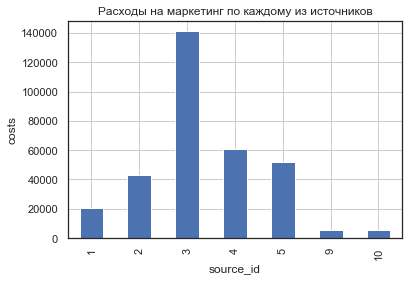

In [91]:
costs.groupby('source_id')['costs'].sum().plot(kind='bar', legend=None, grid=True);
plt.xlabel('source_id');
plt.ylabel('costs');
plt.title('Расходы на маркетинг по каждому из источников');

Теперь посмотрим как менялись траты во времени:

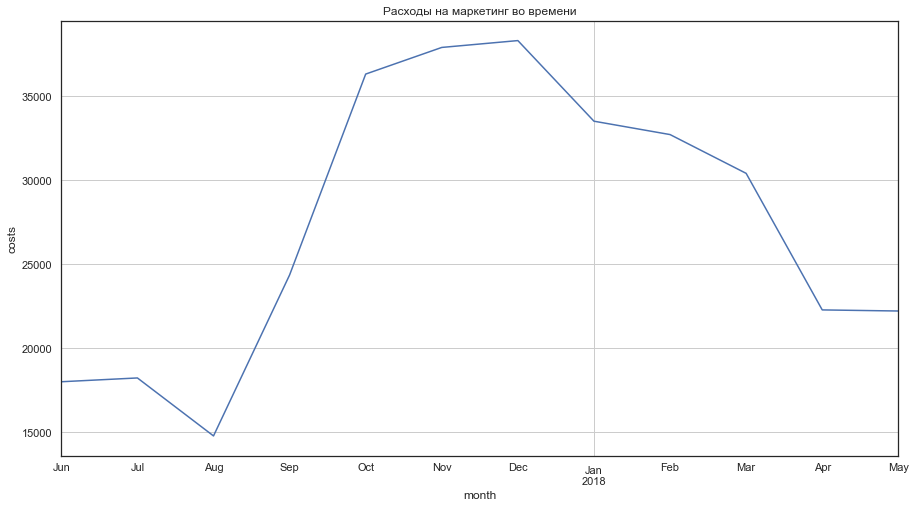

In [92]:
costs['date_month'] = costs['date'].astype('datetime64[M]')
costs.groupby('date_month')['costs'].sum().plot(figsize=(15, 8), legend=None, grid=True);
plt.xlabel('month');
plt.ylabel('costs');
plt.title('Расходы на маркетинг во времени');

Теперь посмотрим как менялись траты по источникам во времени:

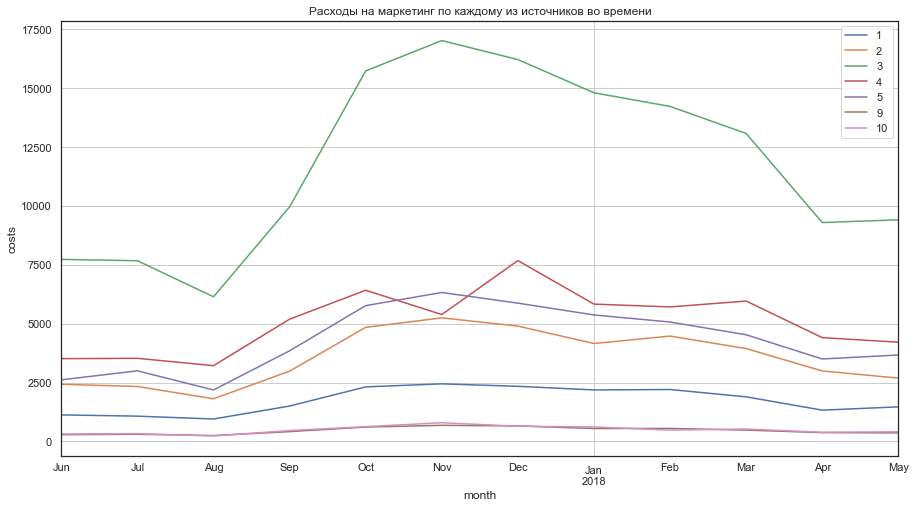

In [93]:
(costs
 .pivot_table(index='date_month', columns='source_id', values='costs', aggfunc='sum')
 .plot(figsize=(15, 8), grid=True));
plt.xlabel('month');
plt.ylabel('costs');
plt.legend();
plt.title('Расходы на маркетинг по каждому из источников во времени');

### Вывод
Общий расход на маркетинг за все время на все источники трафика составил 329 131.
График изменения расходов по месяцам показал примерно такое же поведение, как и MAU. А значит,количество пользователей сильно коррелирует с затратами на привлечение. Невероятно)))
Из последнего графика с расходами в зависимости от источника во времени, стало ясно, что больше всего затрат выходит на 3ий ресурс (141 321),а меньше всего на 9 (5 517) и 10 (5 822).

### Сколько стоило привлечение одного покупателя из каждого источника?
Посчитаем САС

In [94]:
cac = costs.groupby('source_id').agg({'costs': 'sum'}).merge(cohort_sizes, on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


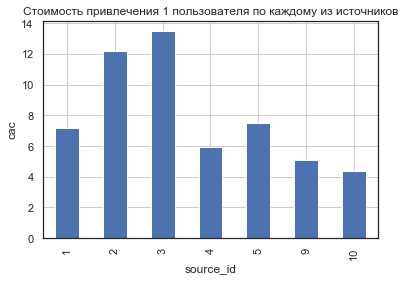

In [95]:
cac['cac'].plot(kind='bar', legend=None, grid=True);
plt.xlabel('source_id');
plt.ylabel('cac');
plt.title('Стоимость привлечения 1 пользователя по каждому из источников');

Посчитаем средний CAC по всей компании:

In [96]:
cac['cac'].mean()

7.963031402494954

### Вывод
Самыми дорогими с точки зрения привлечения одного пользователя являются источники 2 (12.2) и 3 (13.5), а самыми дешевыми 9 (5) и 10 (4.3). Средний CAC по всем источникам - 7.96

## На сколько окупились расходы? (ROI)

In [97]:
roi = ltv.merge(cac[['cac']], on = 'source_id')
roi = roi.div(roi['cac'], axis = 0).drop(columns = 'cac')
roi

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.469110,1.485245,1.492351
2,0.554541,0.659718,0.795940,0.921722,0.974672,1.022526,1.041939,1.060528,1.078791,1.083886,1.093177,1.095915,1.096191
3,0.331831,0.350476,0.360589,0.371142,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.015436,1.016716,1.016750
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,0.764335,0.764335,0.764335


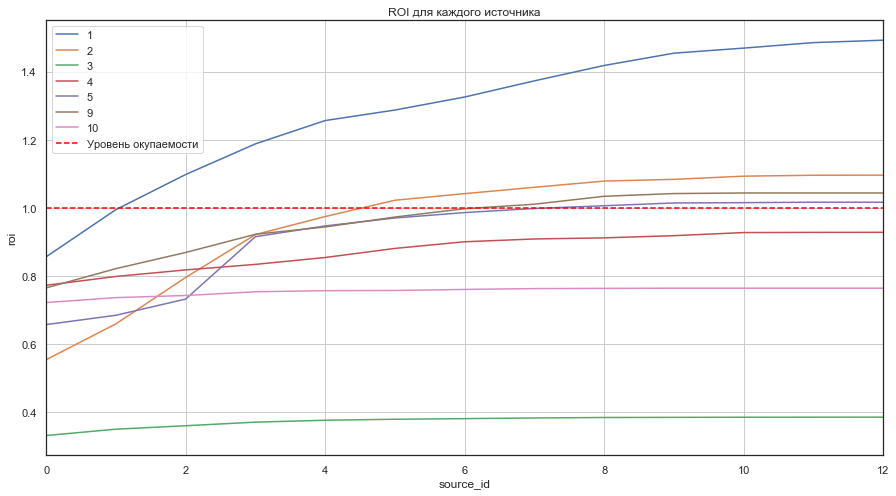

In [98]:
roi.T.plot(figsize=(15, 8), grid=True);
plt.xlabel('source_id');
plt.axhline(y=1, label='Уровень окупаемости', color='red', linestyle='--')
plt.ylabel('roi');
plt.legend();
plt.title('ROI для каждого источника');

### Вывод
построив график ROI для каждого источника, сразу стало ясно, какие источники окупаются быстрее:
самы лучший по окупаемости источник - 1, он окупился на третьем месяце, после него идет истоник 2.
Также слегка попозже смогли окупиться источники 9 и 5.
В течение года так и не смогли окупиться источники 4, 10 и 3. 3ий источник показал себя хуже всех, хотя именно на него потратили больше всего денег.

<a id='cell6'></a>
# Шаг 3. Напишем вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег?

Наша работа состояла из следующих шагов:

## **Шаг 1. Загрузили данные и подготовили их к анализу.**

Мы выгрузили из файлов данные о визитах, заказах и расходах в датафреймы, оказалось, что пропусков в данных не было, так что мы переименовали столбцы для дальнейшего удобства и изменили тип данных в столбцах содержащих даты на datetime. 

## **Шаг 2. Построили отчёты и посчитали метрики**

### **Продукт**

1. **Сколько людей пользуются в день, неделю, месяц?**

В среднем в Яндекс.Афиша с июня 2017 года по май 2018 было:
- 907 уникальных пользователей в день
- 5716 уникальных пользователей в неделю
- 23228 уникальных пользователей в месяц
При этом средний DAU/WAU в этом периоде составил 15% и DAU/MAU 3%. Можем сделать предварительный вывод, что Яндекс.Афишей пользуются не постоянно (не кажды день), редко, иначе бы DAU/WAU и DAU/MAU стремились бы к 100%.

Также мы посмотрели, как все эти параметры зависят от устройства, и оказалось, что с десктопа заходят чаще, чем с тачскринов примерно в 2.5 раза (об этом говорят DAU, MAU, WAU), но при этом DAU/WAU и DAU/MAU примерно одинаковые для разных платформ, поэтому можем сделать вывод, что частота дальнейшего использования от девайса не зависит.

Также мы посмотрели, как все эти параметры зависят от источника трафика, и оказалось, что чаще всего заходят из источников 4, 3 и 5 (об этом говорят DAU, MAU, WAU), тогда как источники 7 и 6 привлекают меньше всего трафика (а источник 8 вообще не встретился в датасете). При этом DAU/WAU и DAU/MAU примерно одинаковые для всех источников (от, кроме 6 и 7 (но там слишком мало данных, чтобы нормально об этом судить): 15-17 в случае DAU/WAU и 3.5-4.5 в случае DAU/MAU, поэтому можем сделать вывод, что частота дальнейшего использования от источника также не зависит.

Также мы посмотрели, как DAU, MAU, WAU меняются во времени: 
По DAU можно заметить большой пик (около 3300) в конце ноября, который повлиял также на MAU и WAU. Возможно, в этот день выложили какой-то анонс или билеты на какой-то крутой концерт? или на новогодние ёлки для детей? В остальные дни с июня по октябрь 2017 в среднем было около 500 уникальных пользователей в день, а с октября 2017 по апрель 2018 в среднем около 1200, а после этого пошло на спад и в среднем было около 750. 

И по WAU и MAU мы видим рост уникальных пользователей за период с августа по ноябрь 2017, а после ноября плавный спад.

2. **Сколько сессий в день?**

В среднем в Яндекс.Афиша с июня 2017 года по май 2018 было 987 сессий в день. И по графику (среднее количество сессий в день с разбивкой по месяцам) мы видим рост среднего количества сессий в день за период с августа по ноябрь 2017, а после ноября плавный спад. Как и у MAU.

3. **Сколько длится одна сессия?**

Длительность сессий распределена по Пуассону, средняя длинна сессии составляет 643 секунды (10.5 минут), медианная 300 секунд (5 минут), а мода 60 секунд. Также мы видим большое количество выбросов на ящике с усами. удалять мы их не будем, так как не будем проводить статтесты.

4. **Как часто люди возвращаются?**

Мы рассчитали ретеншен для месячных когорт. В среднем во второй месяц использования возвращается только 6.5% всех пользователей, и от месяца к месяцу в среднем это значение падает, и к десятому месяцу остается только 3.5% от всех пользователей. Также можно заметить, что чем старше когорта, тем хуже она возвращается. Например если сравнить когорты июня и декабря 2017 года, можно увидеть, что процент вернувшихся людей на 5 месяц в 3 раза больше у более ранней когорты. Возможно это сезонность, а возможно и ухудшающие изменения в продукте. Нужно посмотреть на это повнимательнее.

### **Продажи**

1. **Когда люди начинают покупать?**

Длительность от первой сессии до покупки распределена не по Пуассону (так как есть небольшой второй горб), средняя длительность составляет 14950 секунд (примерно 4 часа), медианная 960 секунд (16 минут), а мода 60 секунд. Также мы видим большое количество выбросов на ящике с усами, на них же приходится второй небольшой горб. удалять мы их не будем, так как не будем проводить статтесты. Также мы узнали, что только 16% пользователей вообще совершили покупку.

2. **Сколько раз покупают за период?**

Количество покупок в месяц схоже по поведению с MAU, которое мы визуализировали ранее. Также наблюдается рост с августа по декабрь 2017, а дальше спад до конца периода. Среднее количество покупок в месяц за весь период - 3878. Также, как и в MAU видим, что по покупкам лидирует десктоп перед тачскрином, и источники 3, 4, 5 перед всеми остальными.

3. **Какой средний чек?**

Средний чек за месяц за весь период - 5.86. Также видим пик в декабре (видимо, покупали билеты на какие-то новогодние мероприятия), а также резкий спад в январе - не удивительно, в январе всегда снижается покупательная способность Россиян из-за больших трат перед новым годом.

4. **Сколько денег приносят? (LTV)**

Мы посчитали LTV для каждого источника, получилось, что на 12ый месяц самый большой LTV у источников 1 (13.4) и 2 (10.7), а самый маленький у 10 (3.3) (7ой не берем в счет, так там только 1 пользователь).


### **Маркетинг**

1. **Сколько денег потратили? Всего / на каждый источник / по времени**

Средний расход на маркетинг в месяц на все источники трафика составил 329 131.
График изменения расходов по месяцам показал примерно такое же поведение, как и MAU. А значит,количество пользователей сильно коррелирует с затратами на привлечение. 
Из последнего графика с расходами в зависимости от источника во времени, стало ясно, что больше всего затрат выходит на 3ий ресурс (141 321),а меньше всего на 9 (5 517) и 10 (5 822).

2. **Сколько стоило привлечение одного покупателя из каждого источника?**

Самыми дорогими с точки зрения привлечения одного пользователя являются источники 2 (12.2) и 3 (13.5), а самыми дешевыми 9 (5) и 10 (4.3).

3. **На сколько окупились расходы? (ROI)**

построив график ROI для каждого источника, сразу стало ясно, какие источники окупаются быстрее:
самы лучший по окупаемости источник - 1, он окупился на третьем месяце, после него идет истоник 2.
Также слегка попозже смогли окупиться источники 9 и 5.
В течение года так и не смогли окупиться источники 4, 10 и 3. 3ий источник показал себя хуже всех, хотя именно на него потратили больше всего денег.

### Общий Вывод
С учетом того, что лучше всего окупается 1ый источник, то мы я бы посоветовала вкладывать деньги именно в этот источник, как основной, также можно в меньшем размере вложиться в источники 2, 5 и 9, так как они тоже  окупаются, только позже. А ограничиваться только одним истоником не стоит - нужно использовать все возможные прибыльные источники, чтобы максимизировать количество пользователей и прибыль. 
Точно не стоит тратить деньги на источники 4, 10, а особенно 3. Они только разоряют бизнес. Хотя там могут, конечно, быть другие менее очевидные плюсы, например, виральность (то есть такие пользователи привлекают в послежствии других платящих пользователей), но без дальнейшего анализа тратить денег на них точно не стоит.